In [1]:
import numpy as np
import sys
import os
import glob
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator

mainpath = '/Users/jorgetil/Astro/HITS'
paper_fig_path = '/Users/jorgetil/Astro/HITS/Publications/Paper1'
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 7)
sb.set(style="ticks", color_codes=True, context="poster")
sb.set_style({"xtick.direction": "in","ytick.direction": "in"})

In [2]:
def MAD(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

In [10]:
year = 'Blind15A'
fields_path = '%s/INFO/fields_%s.txt' % (mainpath, year)
fields = np.loadtxt(fields_path, comments = '#', dtype = str)
fields_info = {}

for band in ['g','r','i']:
#for band in ['u']:
    if year == 'Blind14A' and band in ['r','i']: continue
    fields_info_aux = []
    for i,field in enumerate(fields):
        if field == 'Blind15A_03': continue
        print '\r Field: %s' % (field),
        field_df = []
        info_list = np.sort(glob.glob('%s/INFO/%s_info/%s_*_%s.npy' % (mainpath, year, field,band)))
        print len(info_list),
        if len(info_list) == 0: continue
        for info in info_list:
            aux = np.load(info)
            cols = list(aux.dtype.names)
            data = [value for value in aux.item()]
            aux_df = pd.DataFrame(data, index=cols).T
            aux_df['FIELD'] = field
            field_df.append(aux_df)
            #print aux_df
            #break
        
        field_df = pd.concat(field_df, axis=0)
        fields_info_aux.append(field_df)
    
        #if i == 1:break
    fields_info[band] = pd.concat(fields_info_aux, axis=0)
    fields_info[band].reset_index(inplace=True)

 Field: Blind15A_50 2          27      29         0 


In [8]:
print fields_info['g'].columns

Index([u'index', u'FILTER', u'EPOCH', u'MJD', u'EXP_TIME', u'SEEING',
       u'AIRMASS', u'BACK_LEVEL', u'COMPLET_ADU', u'COMPLET_MAG',
       u'STD_EMPTY_AP', u'LIMIT_MAG_EA3', u'LIMIT_MAG_EA5', u'ZP_PS',
       u'FIELD'],
      dtype='object')


In [11]:
print 'g', np.percentile(fields_info['g'].COMPLET_MAG, 80)
print 'g', np.percentile(fields_info['g'].LIMIT_MAG_EA5, 80)
print 'r', np.percentile(fields_info['r'].LIMIT_MAG_EA5, 80)
print 'r', np.percentile(fields_info['r'].COMPLET_MAG, 80)
print 'i', np.percentile(fields_info['i'].LIMIT_MAG_EA5, 80)
print 'i', np.percentile(fields_info['i'].COMPLET_MAG, 80)
#print 'u', np.percentile(fields_info['u'].LIMIT_MAG_EA5, 50)

g 23.9370578785
g 24.2742262907
r 24.0598869991
r nan
i 23.7889156275
i nan


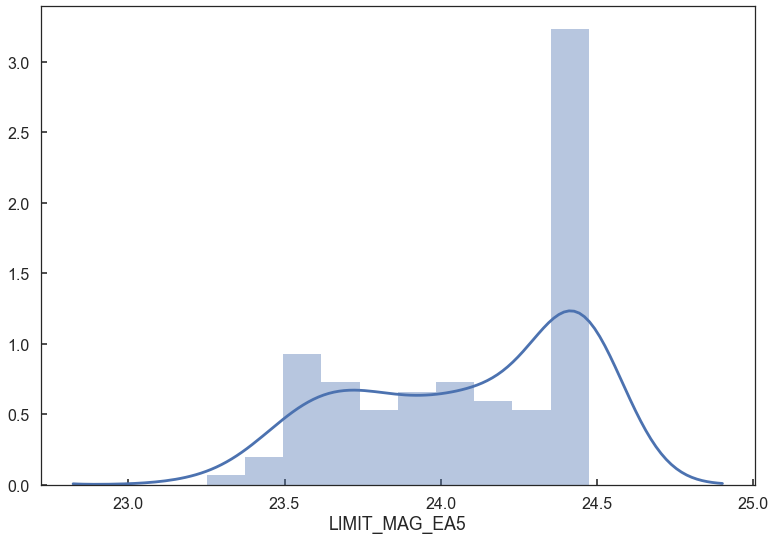

In [12]:
sb.distplot(fields_info['u'].LIMIT_MAG_EA5, bins=10)
plt.show()

In [6]:
print fields_info['g'].shape
fields_info['g'].head()

(1344, 18)


,index,AIRMASS,BACK_LEVEL,COMPLET_ADU,COMPLET_MAG,EPOCH,EXP_TIME,FIELD,FILTER,LIMIT_ADU_SNR5,LIMIT_MAG_EA10,LIMIT_MAG_EA3,LIMIT_MAG_EA5,LIMIT_MAG_SNR5,MJD,SEEING,STD_EMPTY_AP,ZP_PS
0,0,1.19,108.594,247.805,23.9646,02,86,Blind15A_01,g,NaN,NaN,23.8675,23.3129,NaN,57070.1,1.1988,90.3282,25.1137
1,0,1.1,102.391,240.601,24.0092,03,86,Blind15A_01,g,NaN,NaN,24.6387,24.084,NaN,57070.2,1.2123,44.9136,25.1262
2,0,1.27,102.21,235.168,24.0085,04,86,Blind15A_01,g,NaN,NaN,24.2725,23.7179,NaN,57070.3,1.1934,61.4691,25.1007
3,0,1.64,130.437,284.695,23.7212,05,86,Blind15A_01,g,NaN,NaN,24.3424,23.7878,NaN,57071,1.2258,53.5493,25.0209
4,0,1.61,120.168,310.464,23.6324,07,86,Blind15A_01,g,NaN,NaN,25.3828,24.8282,NaN,57071,1.3203,20.6399,25.0262


In [7]:
fields_info['g'].EPOCH = fields_info['g'].EPOCH.astype(int)

In [8]:
print fields_info['g'].query('EPOCH <= 20').shape
print fields_info['g'].query('SEEING <= 1.8 and AIRMASS <= 2 and EPOCH <= 20').shape

fields_info['g'].query('SEEING <= 1.8 and AIRMASS <= 2 and EPOCH <= 20').SEEING.mean() * np.array([0.5, 0.75, 1.0, 1.25, 1.5])

(918, 18)
(736, 18)


array([ 0.64159117,  0.96238675,  1.28318234,  1.60397792,  1.92477351])

01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16

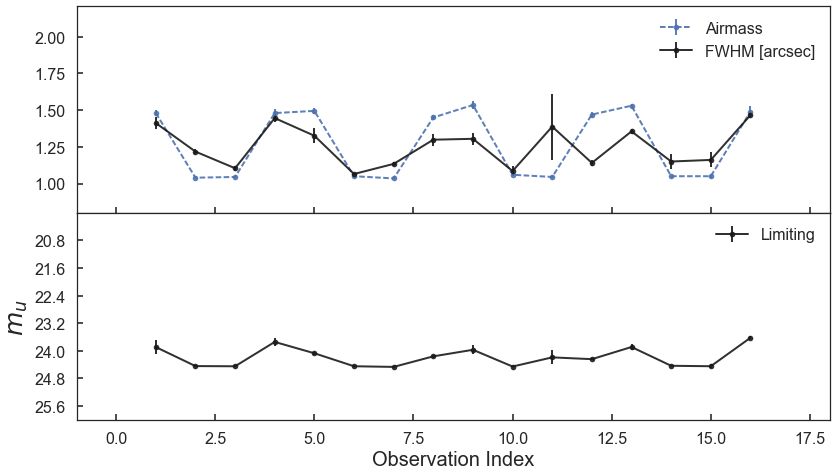

In [13]:
#for band in ['g','r','i']:
for band in ['u']:
    if year == 'Blind14A' and band in ['r','i']: continue
    epochs = []
    complet_mag_mean = []
    complet_mag_std = []
    lim_mag_mean = []
    lim_mag_std = []
    seeing_mean = []
    seeing_std = []
    airmass_mean = []
    airmass_std = []
    for epo in np.sort(fields_info[band].EPOCH.unique()):
        print epo,
        epochs.append(epo)
        com = fields_info[band][fields_info[band].EPOCH == epo].COMPLET_MAG
        lim = fields_info[band][fields_info[band].EPOCH == epo].LIMIT_MAG_EA5
        see = fields_info[band][fields_info[band].EPOCH == epo].SEEING
        air = fields_info[band][fields_info[band].EPOCH == epo].AIRMASS
        
        complet_mag_mean.append(np.median(com))
        complet_mag_std.append(MAD(com))
        
        lim_mag_mean.append(np.percentile(lim, 70))
        lim_mag_std.append(MAD(lim))
        
        seeing_mean.append(np.median(see))
        seeing_std.append(MAD(see))
        
        airmass_mean.append(np.median(air))
        airmass_std.append(MAD(air))
        
    complet_mag_mean = np.array(complet_mag_mean)
    complet_mag_std = np.array(complet_mag_std)
    lim_mag_mean = np.array(lim_mag_mean)
    lim_mag_std = np.array(lim_mag_std)
    seeing_mean = np.array(seeing_mean)
    seeing_std = np.array(seeing_std)
    airmass_mean = np.array(airmass_mean)
    airmass_std = np.array(airmass_std)
    epochs = np.array(epochs, dtype=int)
    
    fig, ax = plt.subplots(2,1, figsize=(12,7), sharex=True)
    ax[0].errorbar(epochs, airmass_mean, yerr=airmass_std, 
                   fmt='.--', c='b', alpha=.9, lw=2, label='Airmass')
    ax[0].errorbar(epochs, seeing_mean, yerr=seeing_std, 
                   fmt='.-', c='k', alpha=.9, lw=2, label='FWHM [arcsec]')
    ax[0].legend(loc = 'upper right', fontsize='small')
    ax[0].set_ylim(0.8, np.max([seeing_mean, airmass_mean]) + 3*np.max([seeing_std, airmass_std]))
    ax[0].set_xlim(np.min(epochs)-2,np.max(epochs)+2)
    start, end = ax[0].get_ylim()
    ax[0].yaxis.set_ticks(np.linspace(start, end, 7))
    nbins = len(ax[0].get_yticklabels())
    ax[0].yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='both'))
    
    if band == 'g':
        ax[1].errorbar(epochs, complet_mag_mean, yerr=complet_mag_std, 
                   fmt='.--', c='b', alpha=.9, lw=2, label='Completness')
    ax[1].errorbar(epochs, lim_mag_mean, yerr=lim_mag_std, 
                   fmt='.-', c='k', alpha=.9, lw=2, label='Limiting')
    ax[1].set_xlabel('Observation Index', fontsize=20)
    ax[1].set_ylabel(r'$m_%s$' % band, fontsize=25)
    ax[1].set_ylim(20.,26)
    start, end = ax[1].get_ylim()
    ax[1].yaxis.set_ticks(np.linspace(start, end, 8))
    ax[1].legend(loc = 'upper right', fontsize='small')
    nbins = len(ax[1].get_yticklabels())
    ax[1].yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='both'))
    ax[1].invert_yaxis()
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    fig.savefig('%s/figures/limits_%s_%s.pdf' % (mainpath, year, band), format='pdf', dpi=600,
                bbox_inches='tight')
    plt.show()

In [10]:
empty_ap_all = np.load('%s/INFO/aux_file_for_plots/empty_all.npy' % mainpath)
linear_ap = np.load('%s/INFO/aux_file_for_plots/linear_ap.npy' % mainpath)
sigma_ap = np.load('%s/INFO/aux_file_for_plots/sigma_ap.npy' % mainpath)
[sigma1, alpha, beta] = np.load('%s/INFO/aux_file_for_plots/fit_coef.npy' % mainpath)
fit_bol = True

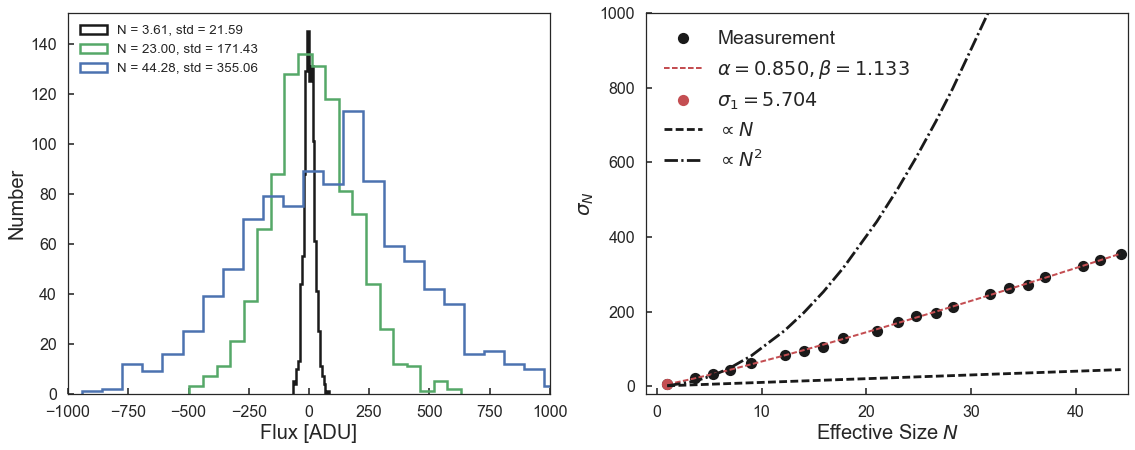

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(19,7))

ax[0].hist(empty_ap_all[1], bins = 20, log = False, color = 'k', alpha = 1, lw=2.5,
           histtype = 'step', normed = False, label = 'N = %.2f, std = %.2f'
           % (linear_ap[1],np.std(empty_ap_all[1])))
ax[0].hist(empty_ap_all[10], bins = 20, log = False, color = 'g', alpha = 1, lw=2.5,
           histtype = 'step', normed = False, label = 'N = %.2f, std = %.2f'
           % (linear_ap[10],np.std(empty_ap_all[10])))
ax[0].hist(empty_ap_all[20], bins = 25, log = False, color = 'b', alpha = 1, lw=2.5,
           histtype = 'step', normed = False, label = 'N = %.2f, std = %.2f'
           % (linear_ap[20],np.std(empty_ap_all[20])))
#ax[0].axvline(np.median(empty_ap_all), color = 'r', label = 'Median %.2f' % np.median(empty_ap_all))
#ax[0].axvline(np.mean(empty_ap_all), color = 'b', label = 'Mean %.2f' % np.mean(empty_ap_all))
ax[0].legend(loc = 'upper left', fontsize='x-small')
ax[0].set_ylabel('Number', fontsize=20)
#ax[0].set_ylim(0,185)
ax[0].set_xlim(-1000,1000)
ax[0].set_xlabel('Flux [ADU]', fontsize=20)

ax[1].plot(linear_ap, sigma_ap, 'ko', label = 'Measurement')
if fit_bol: ax[1].plot(linear_ap, sigma1*alpha*linear_ap**beta, 'r--', lw=2,
                       label = r'$\alpha = %.3f, \beta = %.3f$' % (alpha, beta))
if fit_bol: ax[1].plot(1, sigma1, 'ro', label = r'$\sigma_{1} = %.3f$' % (sigma1))
ax[1].plot(linear_ap, linear_ap, 'k--', label = r'$ \propto N$')
ax[1].plot(linear_ap, linear_ap**2, 'k-.', label = r'$ \propto N^2$')
ax[1].set_ylim(-20,1000)
ax[1].set_xlim(-1,45)
ax[1].legend(loc = 'upper left', fontsize='medium')
ax[1].set_ylabel(r'$\sigma_{N}$', fontsize=20)
ax[1].set_xlabel(r'Effective Size $N$', fontsize=20)

fig.savefig('%s/figures/sky_sigma_%s_%s_2.pdf' % (mainpath, field, 'N1'), format='pdf', dpi=600,
                bbox_inches='tight')
plt.show()

In [35]:
data1 = np.load('%s/INFO/aux_file_for_plots/data1.npy' % mainpath)
data2 = np.load('%s/INFO/aux_file_for_plots/data2.npy' % mainpath)
bins = np.load('%s/INFO/aux_file_for_plots/bins.npy' % mainpath)
compl_adu = np.load('%s/INFO/aux_file_for_plots/compl_adu.npy' % mainpath)
x_mag = np.load('%s/INFO/aux_file_for_plots/x_mag.npy' % mainpath)
ratio = np.load('%s/INFO/aux_file_for_plots/ratio.npy' % mainpath)
compl_mag = np.load('%s/INFO/aux_file_for_plots/compl_mag.npy' % mainpath)
limit = np.load('%s/INFO/aux_file_for_plots/limit.npy' % mainpath)

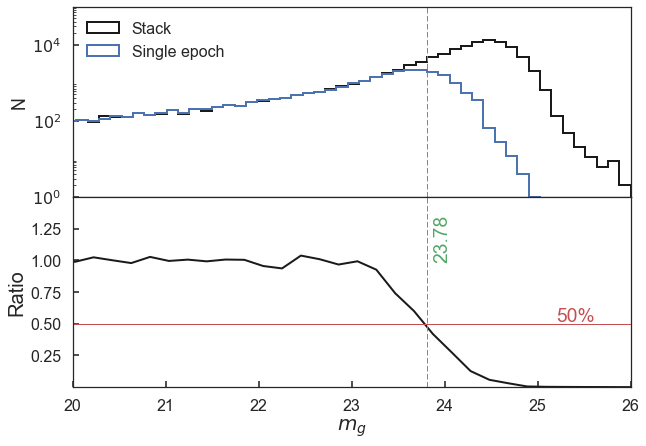

In [49]:
fig, ax = plt.subplots(2, figsize=(10,7))
#fig.suptitle('FRatio of ADU distribution %s'% (pl_name), fontsize = 10)
ax[0].hist(data2, bins = bins, log = True, color = 'k', alpha = 1, \
           histtype = 'step', normed = False, label = 'Stack',lw=2)
ax[0].hist(data1, bins = bins, log = True, color = 'b', alpha = 1, \
           histtype = 'step', normed = False, label = 'Single epoch',lw=2)
ax[0].axvline(compl_adu, color = 'g', ls = '--',lw=1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel('N')
ax[0].legend(loc = 'upper left', fontsize='small')
ax[0].set_xlim(10,100000)
ax[0].set_ylim(1,100000)
ax[0].xaxis.set_visible(False)
ax[1].plot(x_mag, ratio, color = 'k', ls = '-', lw=2)
ax[1].axvline(23.81, color = 'g', ls = '--',lw=1)
ax[1].text(23.88, 1.25,'%.2f' % compl_mag, color='g', rotation='vertical')
ax[1].set_xscale('linear')
ax[1].set_yscale('linear')
ax[1].set_xlabel(r'$m_{g}$', fontsize=20)
ax[1].set_ylabel('Ratio', fontsize=20)
ax[1].set_ylim(0,1.5)
ax[1].axhline(limit, color = 'r', lw=1)
ax[1].text(25.2, 0.52, '50%', color='r')
ax[1].set_xlim(26,20)
nbins = len(ax[1].get_xticklabels())
ax[1].yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='both'))
ax[0].invert_xaxis()
ax[1].invert_xaxis()
fig.subplots_adjust(hspace=0)
fig.savefig('%s/figures/complet_%s_%s.pdf' % (mainpath, field, 'N1'), format='pdf', dpi=600,
                bbox_inches='tight')
plt.show()